In [1]:
import os
os.getcwd()
os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 10000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

In [3]:
def f_lb_theta(theta):
    return -1/np.log(theta)

def f_theta_lb(lb):
    return np.exp(-1/lb)

def f_lb_a(a):
    L_a = 1-np.cosh(a)/np.sinh(a)
    return 1/1-L_a

## Visualized guide to determine parameters

In [4]:
def plot_CC(Cc, ax, show_axes=1, end=1, axeslabel='off'):
    """
    Plot polymer chain.
    
    Args:
        filename: str
    """
            
    ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
            '-', color='#D00000', linewidth=2, alpha = 0.75)
    # ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
    #         'o', markeredgecolor='#800000', markerfacecolor='#D00000')

    # plot chain end
    if end==1:
        ax.plot(Cc[0,0],Cc[1,0],Cc[2,0], 
                    'o', markeredgecolor='#000080', markerfacecolor='#0000D0')
        ax.plot(Cc[0,-1],Cc[1,-1],Cc[2,-1], 
                    'o', markeredgecolor='#008000', markerfacecolor='#00D000')

    #CM = np.mean(Cc_backbone,axis=1)
    CT = np.array([np.max(Cc[0,:])+np.min(Cc[0,:]),
                    np.max(Cc[1,:])+np.min(Cc[1,:]),
                    np.max(Cc[2,:])+np.min(Cc[2,:])])/2
    d_box = np.max([np.max(Cc[0,:])-np.min(Cc[0,:]),
                    np.max(Cc[1,:])-np.min(Cc[1,:]),
                    np.max(Cc[2,:])-np.min(Cc[2,:])])

    if axeslabel=='on':
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$z$')

    if show_axes==0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        #ax.axis('off')

    ax.set_xlim([CT[0]-d_box/2, CT[0]+d_box/2])
    ax.set_ylim([CT[1]-d_box/2, CT[1]+d_box/2])
    ax.set_zlim([CT[2]-d_box/2, CT[2]+d_box/2])
    ax.set_box_aspect([1,1,1])

In [5]:
def plot_chain_params(kappa, epsilon, chain, fig, loc, rows):
    # call class
    chain01 = chain
    chain01.d_exc = 1

    chain01.apply_SA = 0
    chain01.d_exc = 0.1
    chain01.f = 0.0
    # Chain stiffness
    chain01.kappa = kappa
    chain01.epsilon = epsilon

    chain_Cc_list = []
    for grid in ['SC','RB','RT']:
        chain01.grid = grid
        chain01.chain_grid()
        filename_chain = './test.png'
        # chain01.plot(filename=filename_chain, show_axes=0, save=1, end=1, fig = plt.figure(figsize=(4, 4),dpi=192))
        chain_Cc_list.append(chain01.Cc)
        
    for i in range(3):
        ax = fig.add_subplot(rows,4,i+1+4*loc, projection='3d')
        chain_Cc = chain_Cc_list[i]
        plot_CC(chain_Cc, ax, show_axes=1, end=1, axeslabel='off')

    # plot Rayleigh chain
    chain01.a = kappa
    chain01.chain()

    ax = fig.add_subplot(rows,4,4+4*loc, projection='3d')
    plot_CC(chain01.Cc, ax, show_axes=1, end=1, axeslabel='off')
    plt.tight_layout()


[5, 0]
[15, 0]
[45, 0]
[135, 0]


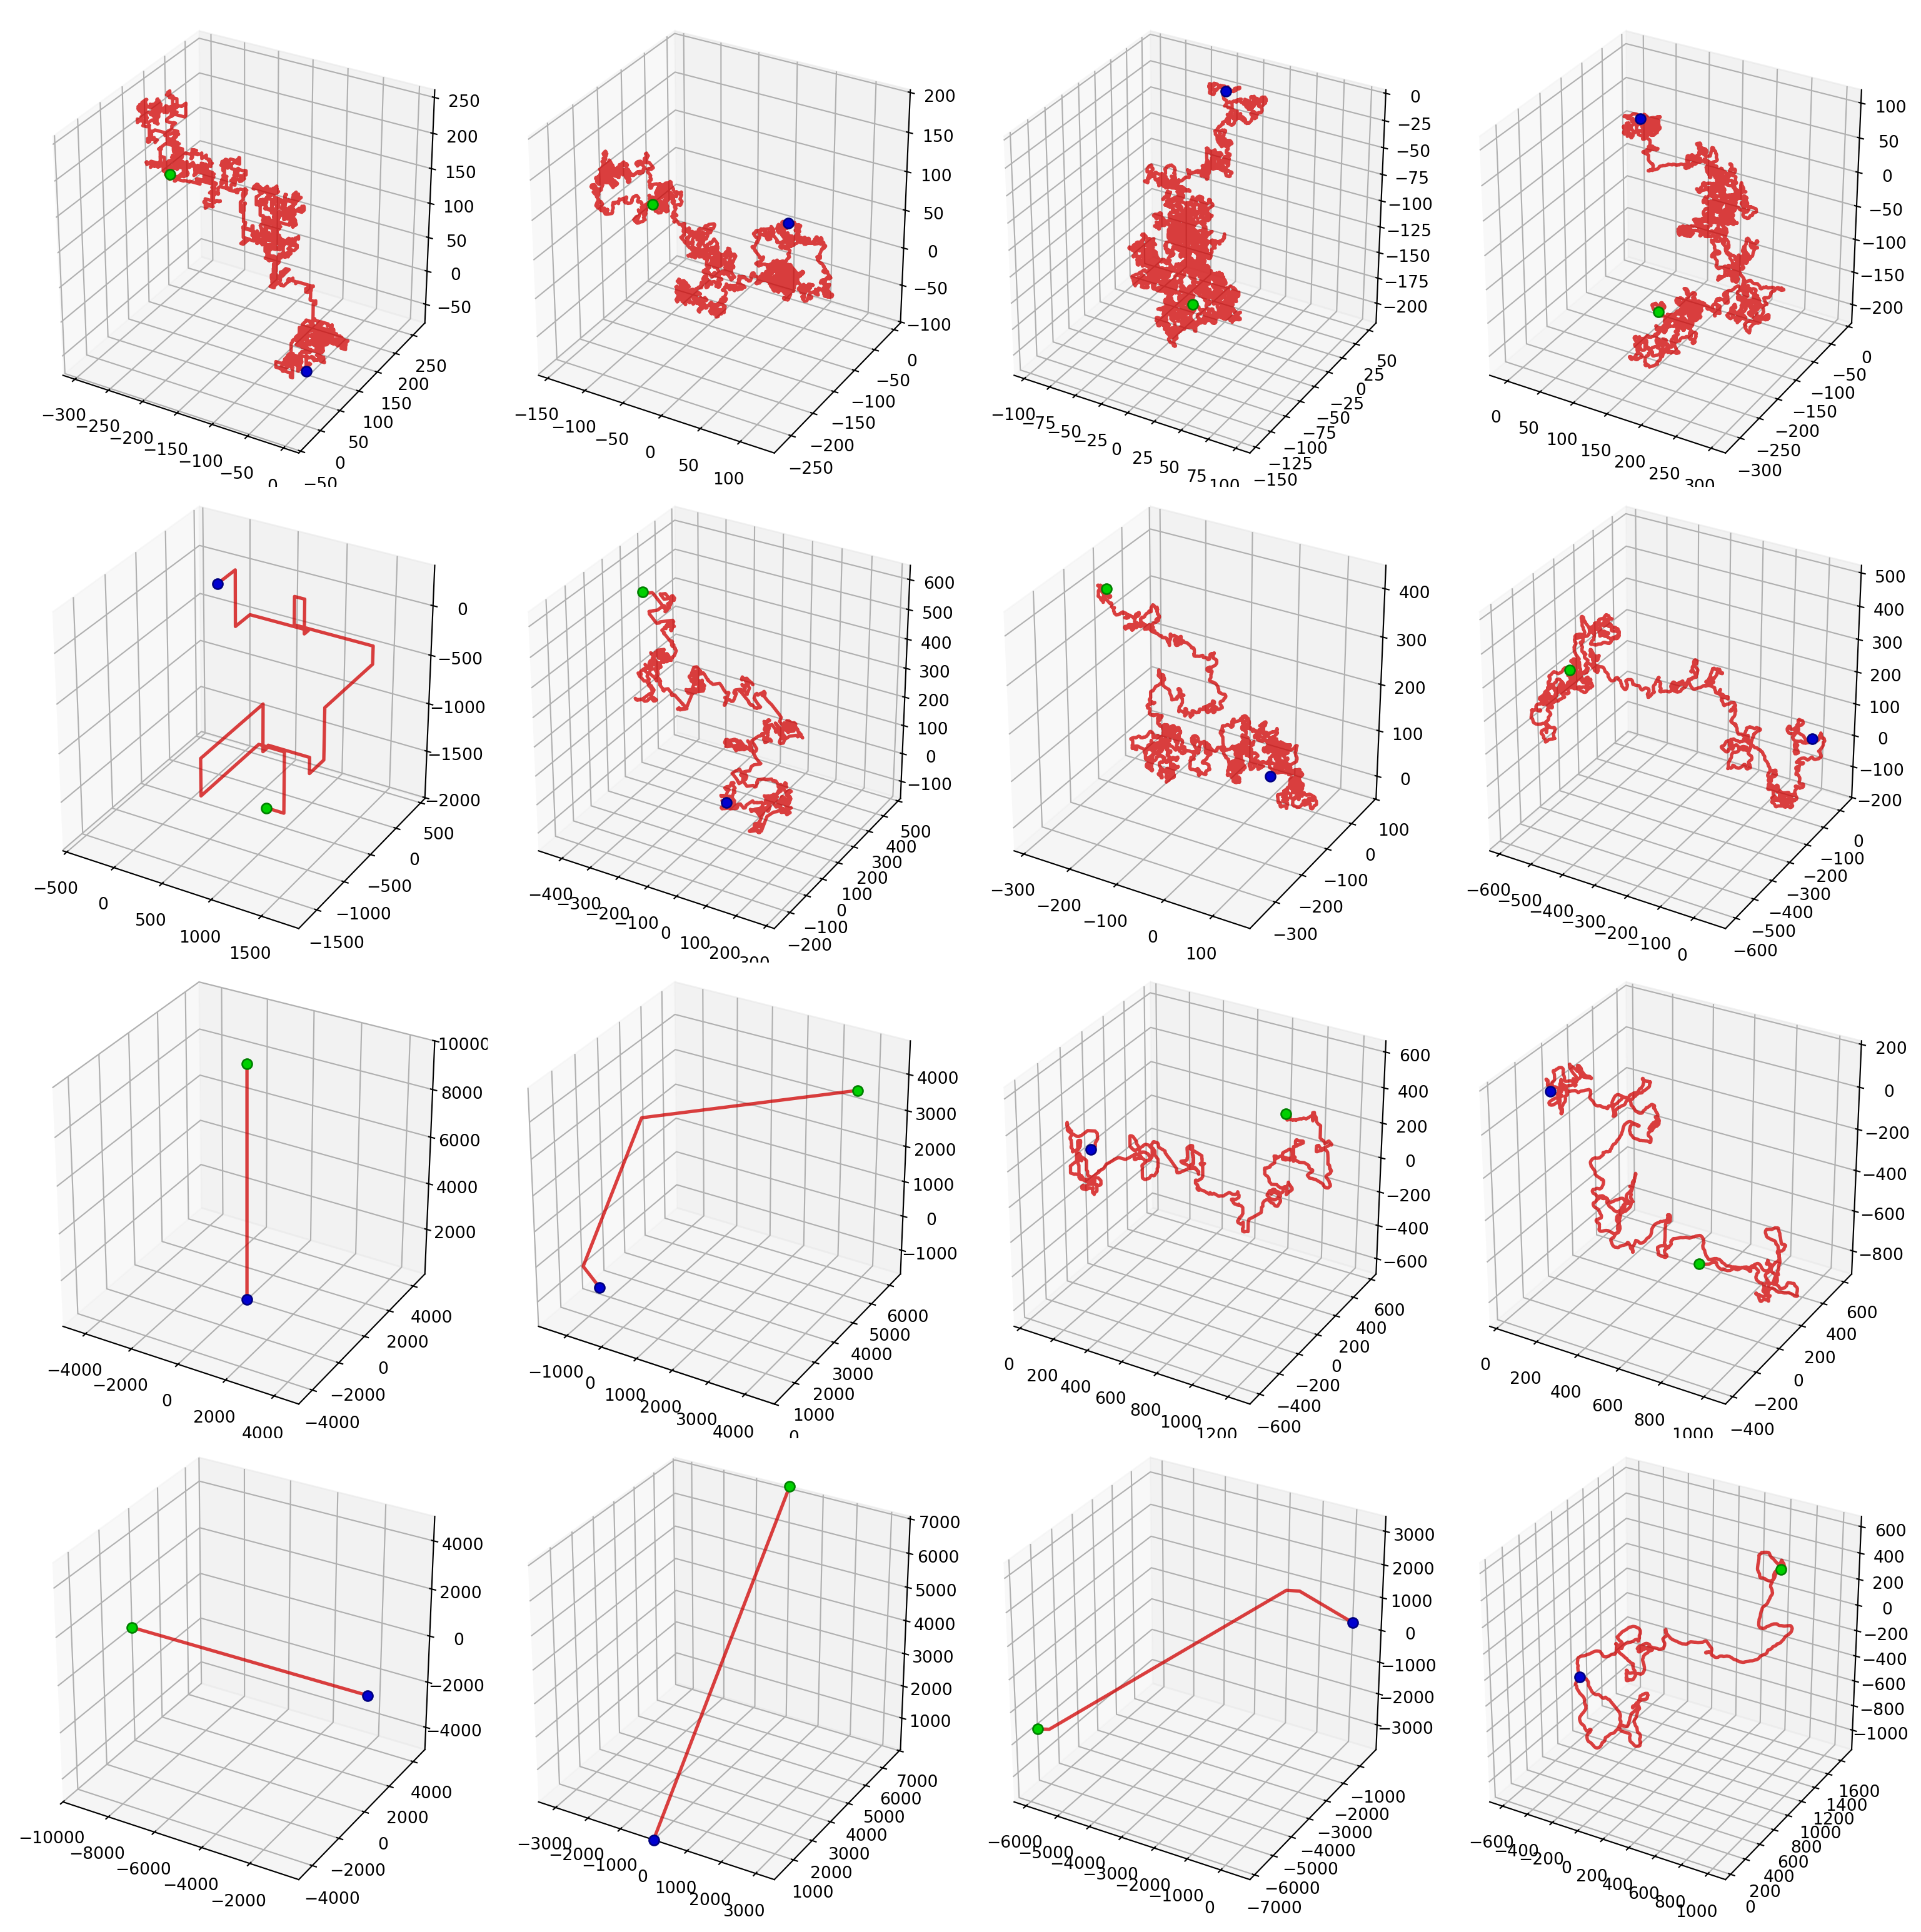

In [13]:
kappa_list = np.array([5,15,45,135])
epsilon_list = [0]

parameters_list = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 1
chain.d_exc = 0.1
chain.f = 0.0

fig = plt.figure(figsize=(16, 16),dpi=192)

for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)
    plot_chain_params(kappa, epsilon, chain, fig, loc=j, rows=len(kappa_list))

## Generate scattering function associated with given parameters

In [7]:
def eval_sq(kappa, epsilon, chain, qq, n_sample = 20, n_merge = 4, rayleigh=False):
    ## generate spectra of three different grids
    S_q_list = []

    chain_Cc_list = []
    for i, grid in enumerate(['SC','RB','RT']):
        S_q_i = np.zeros_like(qq)
        E_total = 0
        for j in trange(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon


            chain.chain_grid()
            N = chain.N
            chain_box = chain.box
            
            chain.scatter_direct(qq,n_merge=n_merge)
            S_q_i = S_q_i + chain.S_q

        #     E_j = np.sum(chain.E_list)
        #     E_total+=E_j
        # E_total = E_total/n_sample
        # print(E_total)

        qq = chain.qq    
        S_q_list.append(S_q_i/n_sample) # Append the S(Q) of given grid type

    ## Rayleigh chain
    if rayleigh:
        S_q_i = np.zeros_like(qq)
        chain.a = kappa
        for j in trange(n_sample):
            chain.chain()
            chain.scatter_direct(qq,n_merge=n_merge)
            S_q_i = S_q_i + chain.S_q
        S_q_list.append(S_q_i/n_sample)

    return np.array(S_q_list)

In [8]:
# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 1
chain.d_exc = 0.1
chain.f = 0.0

# Q points, QL/2pi = 0.1 to 1000
n_q = 101
qq = 2*np.pi*(np.logspace(-1,3,n_q))/N_backbone

parameters_list = []
S_q_list_param = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])

        # Chain stiffness
        chain.kappa = kappa
        chain.epsilon = epsilon

        S_q_list_grid = eval_sq(kappa, epsilon, chain, qq, n_sample = 8, n_merge = 8, rayleigh=True)
        S_q_list_param.append(S_q_list_grid)

  0%|                                                                               | 0/8 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:58<00:00,  7.37s/it]


In [9]:
from Sk import S_rod

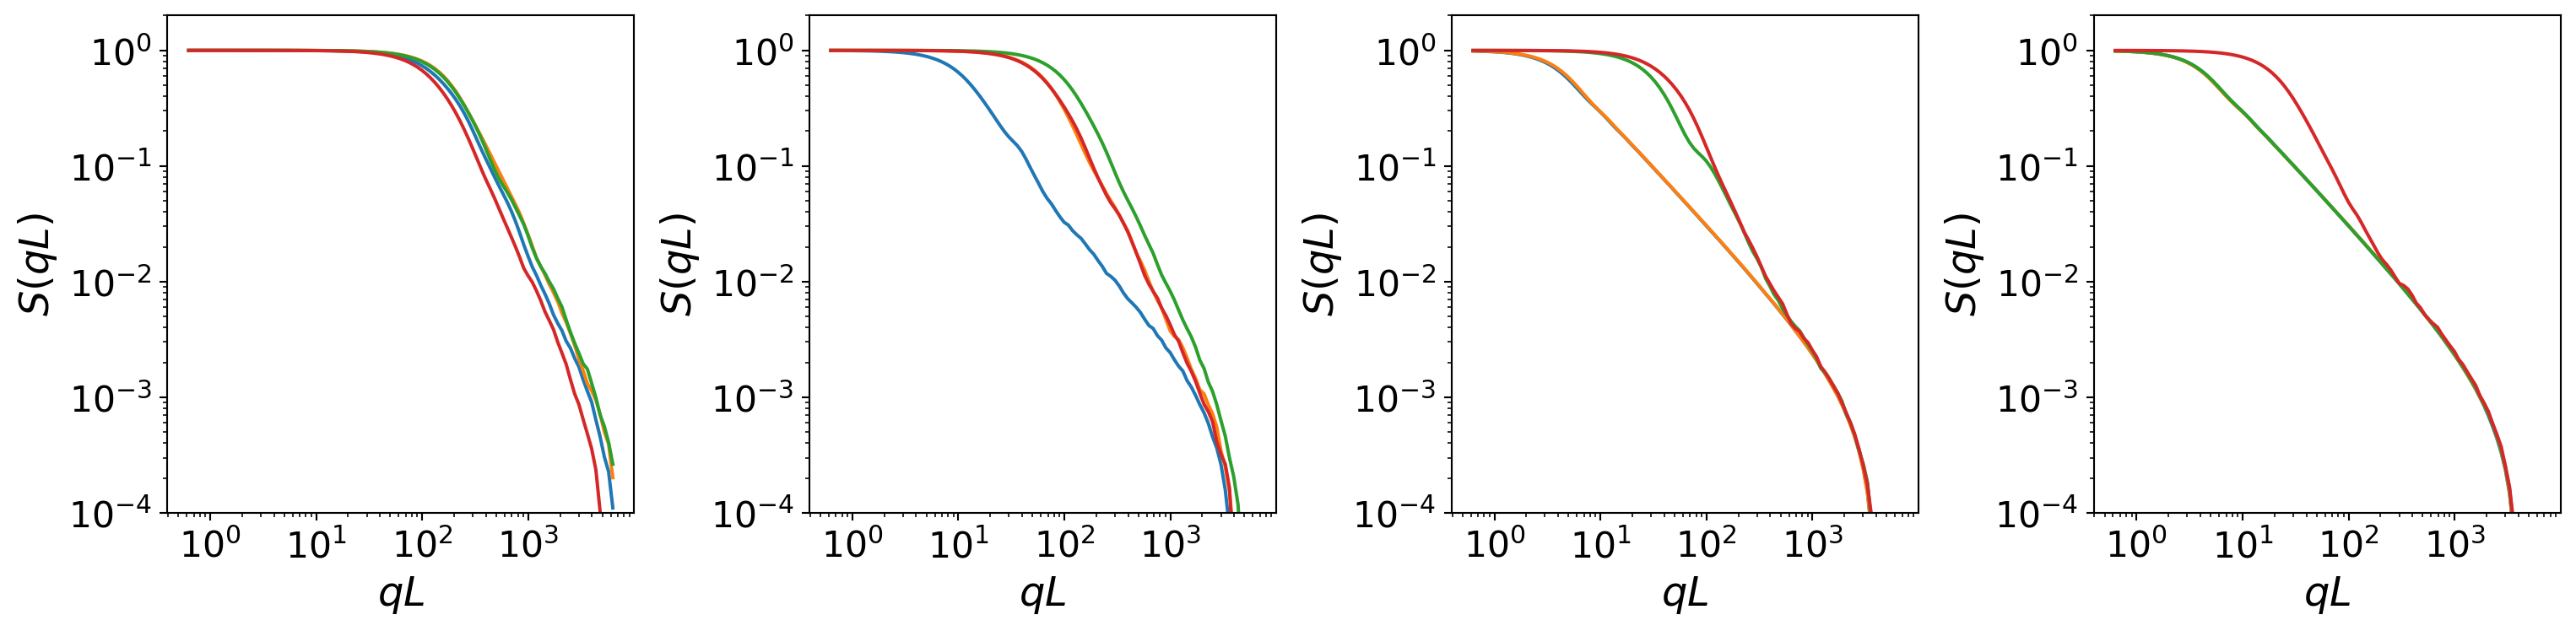

In [10]:
fig = plt.figure(figsize=(16, 4),dpi=192)

for j, params in enumerate(parameters_list):
    S_q_list = S_q_list_param[j]
    ax = fig.add_subplot(1,4,j+1)
    for i, grid in enumerate(['SC','RB','RT']):
        ax.plot(qq*N_backbone,S_q_list[i])
    ax.plot(qq*N_backbone,S_q_list[3])
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-4,2])
    ax.set_xlabel(r'$qL$',fontsize=18)
    ax.set_ylabel(r'$S(qL)$',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()

In [11]:
S_q_list_param = np.array(S_q_list_param)
S_q_list_param.shape

(4, 4, 101)

In [12]:
S_q_list_param = np.array(S_q_list_param)
mdic = {"S_q_list_param":S_q_list_param, "qq":qq, "parameters_list":parameters_list}
savemat("test_S_q_list_param.mat",mdic)